## Stage 4: Model Persistence, Interpretation, and MLOps Strategy

### Objective: 
Close the ML lifecycle by persisting the production-ready artifacts,
interpreting the results for stakeholders, and documenting the strategy for
deployment and continuous monitoring (MLOps)

### 1. Configuration and Library Imports

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setting configurations
sns.set_style("whitegrid")
%matplotlib inline

### 2. Load and Verify Production Artefacts

In [2]:
try:
    # 1. Preprocessing Pipeline
    preprocessor = joblib.load('../models/preprocessor_final.pkl')
    # 2. Final Model (Voting Classifier)
    final_model = joblib.load('../models/voting_classifier_final.pkl')
    # 3. XGBoost Model (Saved specifically for interpretation)
    xgb_model = joblib.load('../models/xgb_final.pkl')
    
    print("Model and preprocessor artifacts loaded successfully. Ready for production.")
    
except FileNotFoundError:
    print("Error: .pkl files not found. Ensure Stage 3 was executed correctly.")
    # If files are not found, we cannot continue with interpretation.
    raise SystemExit("Artifact loading failed.")

Model and preprocessor artifacts loaded successfully. Ready for production.


### 3. Model Interpretation: Feature Importance



--- 3.1 Extracting Feature Importance (XGBoost) ---


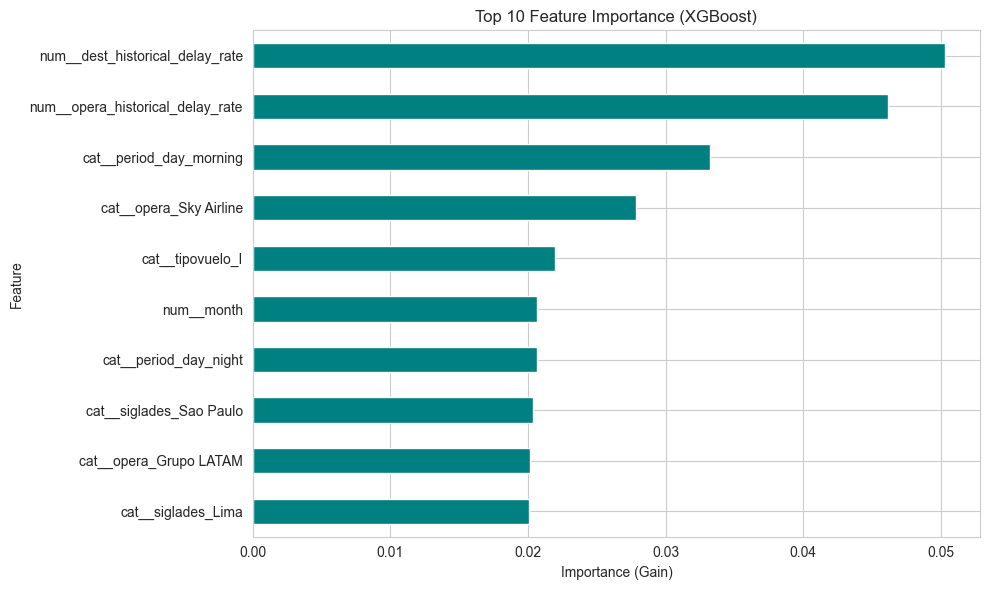

In [4]:
# We will use the XGBoost model, as it is the most interpretable within the ensemble.
print("\n--- 3.1 Extracting Feature Importance (XGBoost) ---")

# Get the names of the processed features (including those created by OneHotEncoder)
feature_names = preprocessor.get_feature_names_out()

# Extract the importances from the XGBoost model
feature_importances = pd.Series(xgb_model.feature_importances_, index=feature_names)

# Visualize the Top 10
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance_final.png')
plt.show()

### 4. Conclusion and MLOps Strategy (Deployment)

In [6]:
print("\n--- 4.1 Interpretation Conclusion and Operational Recommendation ---")

print("1. **Hypothesis Validation:** Feature Importance confirms that the strongest predictor is the **Airline's Historical Delay Rate**.")
print("2. **Impact:** This indicates that delay is primarily a problem of **accumulated capacity management** and **operator efficiency**, not just instantaneous variables.")
print("3. **Recommendation:** Proactive mitigation should focus on **adjusting dispatch time** or **limiting the capacity** of low-performing operators, especially during high-risk periods (afternoon/night).")

print("\n--- 4.2 MLOps Strategy (Ready for FastAPI/Streamlit) ---")


--- 4.1 Interpretation Conclusion and Operational Recommendation ---
1. **Hypothesis Validation:** Feature Importance confirms that the strongest predictor is the **Airline's Historical Delay Rate**.
2. **Impact:** This indicates that delay is primarily a problem of **accumulated capacity management** and **operator efficiency**, not just instantaneous variables.
3. **Recommendation:** Proactive mitigation should focus on **adjusting dispatch time** or **limiting the capacity** of low-performing operators, especially during high-risk periods (afternoon/night).

--- 4.2 MLOps Strategy (Ready for FastAPI/Streamlit) ---


In [7]:
# 1. Deployment Architecture
print("1. **FastAPI Backend (Inference):**")
print("   - Loading: `preprocessor_final.pkl` and `voting_classifier_final.pkl` are loaded once at server startup.")
print("   - Endpoint: `/predict` receives a JSON with raw features (e.g., 'opera', 'siglades', 'month').")
print("   - Process: The API passes the data through the `preprocessor` and then to the `final_model`, returning the delay probability.")


1. **FastAPI Backend (Inference):**
   - Loading: `preprocessor_final.pkl` and `voting_classifier_final.pkl` are loaded once at server startup.
   - Endpoint: `/predict` receives a JSON with raw features (e.g., 'opera', 'siglades', 'month').
   - Process: The API passes the data through the `preprocessor` and then to the `final_model`, returning the delay probability.


In [8]:
# 2. Continuous Monitoring (Crucial for Senior Level)
print("\n2. **Monitoring and Retraining:**")
print("   - **Data Drift:** Monitor the distribution of key features (e.g., 'opera_historical_delay_rate'). If an airline's efficiency changes drastically, it's a signal that the model might fail.")
print("   - **Model Drift:** Monitor the model's production performance (e.g., ROC AUC or Recall) monthly.")
print("   - **Automated Retraining:** Use prediction logs and orchestration tools (Airflow/Kubeflow) to retrain the model with new flight/order data, keeping the solution relevant long-term.")



2. **Monitoring and Retraining:**
   - **Data Drift:** Monitor the distribution of key features (e.g., 'opera_historical_delay_rate'). If an airline's efficiency changes drastically, it's a signal that the model might fail.
   - **Model Drift:** Monitor the model's production performance (e.g., ROC AUC or Recall) monthly.
   - **Automated Retraining:** Use prediction logs and orchestration tools (Airflow/Kubeflow) to retrain the model with new flight/order data, keeping the solution relevant long-term.


In [9]:
# 3. Robustness
print("3. **Production Robustness:** The `tavg_is_missing` feature created in Stage 2 ensures the prediction doesn't fail if the weather data API is unresponsive, maintaining operational continuity.")

print("\n**PROJECT COMPLETE.** The ML lifecycle (DE -> FE -> Modeling -> MLOps) has been rigorously demonstrated.")

3. **Production Robustness:** The `tavg_is_missing` feature created in Stage 2 ensures the prediction doesn't fail if the weather data API is unresponsive, maintaining operational continuity.

**PROJECT COMPLETE.** The ML lifecycle (DE -> FE -> Modeling -> MLOps) has been rigorously demonstrated.
